In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

## **Setup**

In [48]:
# Fix randomization
SEED = 1234
np.random.seed(SEED)

# Global parameters
T = 10000
N_CUSTOMERS = 100
COST = 10
PRICE_MAX = 30
INTERVAL_LENGTH = 2500
N_INTERVALS = math.ceil(T / INTERVAL_LENGTH)

# Parameters for SW and CUSUM
U_T = N_INTERVALS - 1                       # max number of abrupt changes
W = int(2 * np.sqrt(T * np.log(T) / U_T))   # SW: window size, assuming U_T is known
M = int(np.log(T / U_T))                    # CUSUM: robustness of change detection
h = 2 * np.log(T / U_T)                     # CUSUM: sensitivity of detection, threshold for cumulative deviation
alpha = np.sqrt(U_T * np.log(T / U_T) / T)  # CUSUM: probability of extra exploration

N_TRIALS = 2

COLORS = ['red', 'green', 'orange', 'purple']

# Non-stationary conversion probabilities
conversion_probabilities = [
    lambda price: 1 - price / 40,
    lambda price: np.exp(- (price - 10) / 10),
    lambda price: - (np.tanh(price - 15) - 1) / 2,
    lambda price: (price - PRICE_MAX) ** 2 / (PRICE_MAX ** 2)
]

# Action space
K = 20
prices = np.linspace(COST, PRICE_MAX, K)

# Demand curves
demand_curves = [N_CUSTOMERS * conversion_probabilities[i](prices) for i in range(N_INTERVALS)]

# Profit curves
profit_curves = [N_CUSTOMERS * (prices - COST) * conversion_probabilities[i](prices) for i in range(N_INTERVALS)]

# Best prices
best_prices_indices = [np.argmax(profit_curve) for profit_curve in profit_curves]
best_prices = [prices[i] for i in best_prices_indices]

In [49]:
# Create a function to rescale the rewards based on the maximum possible reward
max_possible_reward = N_CUSTOMERS * (PRICE_MAX - COST)

def rescale_reward(reward):
    return reward / max_possible_reward

In [50]:
max_possible_reward

2000

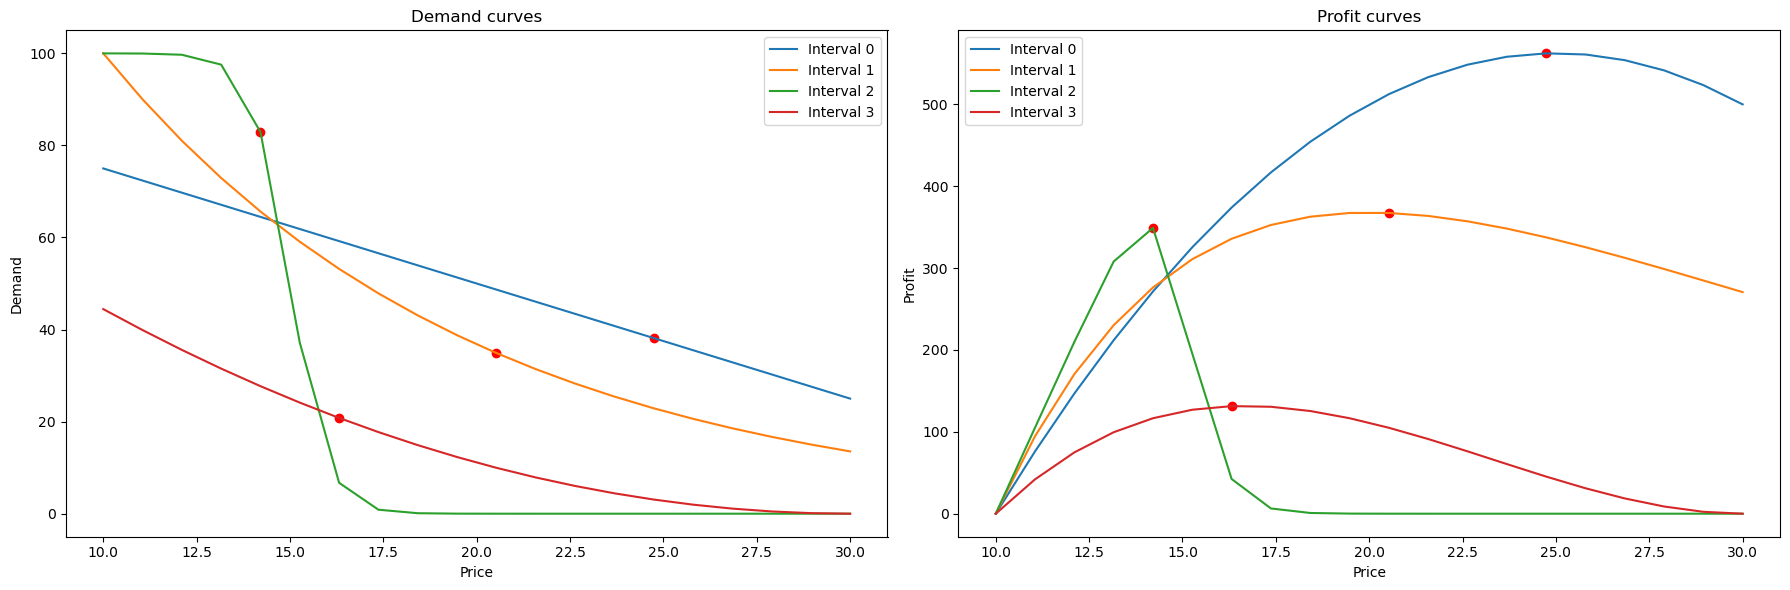

In [51]:
# Plot the demand curves together in one subplot, and the profit curves in another
# Also plot the best prices in both subplots
fig, axs = plt.subplots(1, 2, figsize=(18, 6))
for i in range(N_INTERVALS):
    axs[0].plot(prices, demand_curves[i], label=f'Interval {i}')
    axs[0].scatter(best_prices[i], demand_curves[i][best_prices_indices[i]], color='red')
    axs[1].plot(prices, profit_curves[i], label=f'Interval {i}')
    axs[1].scatter(best_prices[i], profit_curves[i][best_prices_indices[i]], color='red')
axs[0].set_title('Demand curves')
axs[0].set_xlabel('Price')
axs[0].set_ylabel('Demand')
axs[0].legend()
axs[1].set_title('Profit curves')
axs[1].set_xlabel('Price')
axs[1].set_ylabel('Profit')
axs[1].legend()
plt.tight_layout()
plt.show()

In [52]:
for i in range(N_INTERVALS):
    print(f'Best price for interval {i}: {best_prices[i]} - Price index: {best_prices_indices[i]}')

Best price for interval 0: 24.736842105263158 - Price index: 14
Best price for interval 1: 20.526315789473685 - Price index: 10
Best price for interval 2: 14.210526315789473 - Price index: 4
Best price for interval 3: 16.315789473684212 - Price index: 6


## **Environment**

In [53]:
class NonStationaryPricingEnvironment:
    def __init__(self, conversion_probabilities, cost, interval_length, seed=None):
        if seed is not None:
            np.random.seed(seed)
        self.conversion_probabilities = conversion_probabilities
        self.cost = cost
        self.interval_length = interval_length
        self.t = 0
        self.current_interval = 0

    def round(self, price_t, n_t):
        demand_t = np.random.binomial(n_t, self.conversion_probabilities[self.current_interval](price_t))
        reward_t = demand_t * (price_t - self.cost)
        self.t += 1
        if self.t % self.interval_length == 0:
            self.current_interval += 1
        return demand_t, reward_t

## **Clairvoyant**

In [54]:
# Let's compute the clairvoyant rewards in expectation -> best policy in hindsight
reward_function = lambda price, n_sales: n_sales * (price - COST)
maximum_profit = reward_function(prices.max(), N_CUSTOMERS)

best_rewards = np.array([reward_function(prices[best_price_index], N_CUSTOMERS) for best_price_index in best_prices_indices])
best_cumulative_reward = sum(best_rewards)

expected_clairvoyant_rewards = np.array([])
for i in range(N_INTERVALS):
    profit_curve = profit_curves[i]
    best_price_index = best_prices_indices[i]
    partial_expected_clairvoyant_rewards = np.repeat(profit_curve[best_price_index], INTERVAL_LENGTH)
    expected_clairvoyant_rewards = np.append(expected_clairvoyant_rewards, partial_expected_clairvoyant_rewards)

expected_clairvoyant_rewards

array([562.32686981, 562.32686981, 562.32686981, ..., 131.40885455,
       131.40885455, 131.40885455])

In [55]:
# Rescale the expected clairvoyant rewards
expected_clairvoyant_rewards = rescale_reward(expected_clairvoyant_rewards)
expected_clairvoyant_rewards

array([0.28116343, 0.28116343, 0.28116343, ..., 0.06570443, 0.06570443,
       0.06570443])

## **Make sure the environment is non-stationary**

In [56]:
class UCB1Agent:
    def __init__(self, K, T, range=1):
        self.K = K
        self.T = T
        self.range = range
        self.action_t = None
        self.average_rewards = np.zeros(K)
        self.n_pulls = np.zeros(K)
        self.t = 0

    def pull_arm(self):
        if self.t < self.K:
            self.action_t = self.t
        else:
            ucb_values = self.average_rewards + self.range * np.sqrt(2 * np.log(self.t) / self.n_pulls)
            self.action_t = np.argmax(ucb_values)
        return self.action_t

    def update(self, reward_t):
        self.n_pulls[self.action_t] += 1
        self.average_rewards[self.action_t] += (reward_t - self.average_rewards[self.action_t]) / self.n_pulls[self.action_t]
        self.t += 1

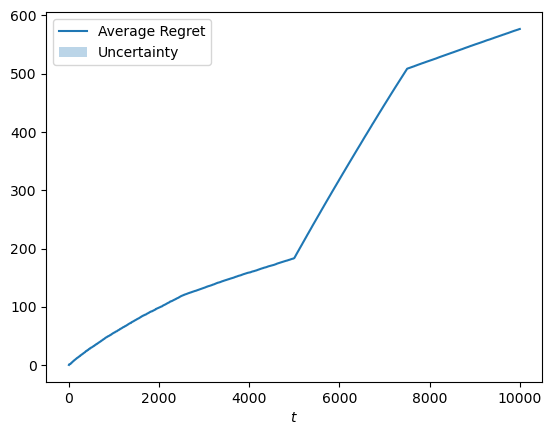

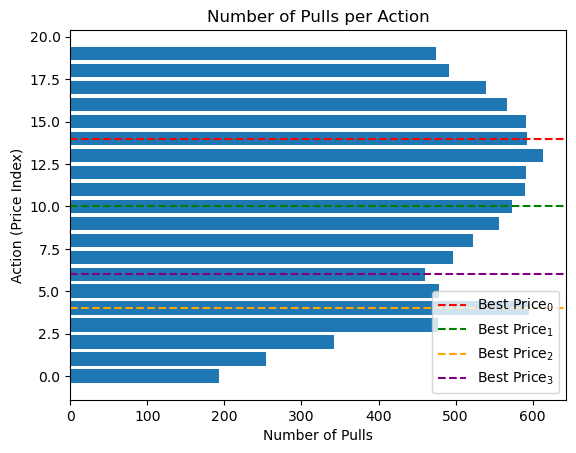

In [57]:
regret_per_trial = []

for seed in range(N_TRIALS):
    env = NonStationaryPricingEnvironment(conversion_probabilities, COST, INTERVAL_LENGTH, seed=seed)
    agent = UCB1Agent(K, T)

    agent_rewards = np.array([])

    for t in range(T):
        price_index_t = agent.pull_arm()
        price_t = prices[price_index_t]
        demand_t, reward_t = env.round(price_t, N_CUSTOMERS)
        reward_t = rescale_reward(reward_t) # Rescale the reward
        agent.update(reward_t)

        agent_rewards = np.append(agent_rewards, reward_t)

    cumulative_regret = np.cumsum(expected_clairvoyant_rewards - agent_rewards)
    regret_per_trial.append(cumulative_regret)

regret_per_trial = np.array(regret_per_trial)

average_regret = regret_per_trial.mean(axis=0)
regret_std = regret_per_trial.std(axis=0)
regret_std_normalized = regret_std / np.sqrt(N_TRIALS)


# Plotting
plt.plot(np.arange(T), average_regret, label='Average Regret')
plt.fill_between(np.arange(T),
                 average_regret - regret_std_normalized,
                 average_regret + regret_std_normalized,
                 alpha=0.3,
                 label='Uncertainty')
plt.xlabel('$t$')
plt.legend()
plt.show()

plt.barh(np.arange(K), agent.n_pulls)
for i in range(N_INTERVALS):
    plt.axhline(y=best_prices_indices[i], color=COLORS[i], linestyle='--', label=f'Best Price$_{i}$')
plt.xlabel('Number of Pulls')
plt.ylabel('Action (Price Index)')
plt.legend()
plt.title('Number of Pulls per Action')
plt.show()

## **Sliding Window Approach**

In [58]:
class SWUCBAgent:
    def __init__(self, K, T, W, range=1):
        self.K = K
        self.T = T
        self.W = W
        self.range = range
        self.action_t = None
        self.cache = np.repeat(np.nan, repeats=K * W).reshape(W, K)
        self.n_pulls = np.zeros(K)
        self.t = 0

    def pull_arm(self):
        if self.t < self.K:
            self.action_t = self.t
        else:
            n_pulls_last_w = self.W - np.isnan(self.cache).sum(axis=0)
            average_last_w = np.nanmean(self.cache, axis=0)
            ucbs = average_last_w + self.range * np.sqrt(2 * np.log(self.W) / n_pulls_last_w)
            self.action_t = np.argmax(ucbs)
        return self.action_t

    def update(self, reward_t):
        self.n_pulls[self.action_t] += 1
        self.cache = np.delete(self.cache, (0), axis=0) # remove oldest observation
        new_samples = np.repeat(np.nan, self.K)
        new_samples[self.action_t] = reward_t
        self.cache = np.vstack((self.cache, new_samples)) # add new observation
        self.t += 1

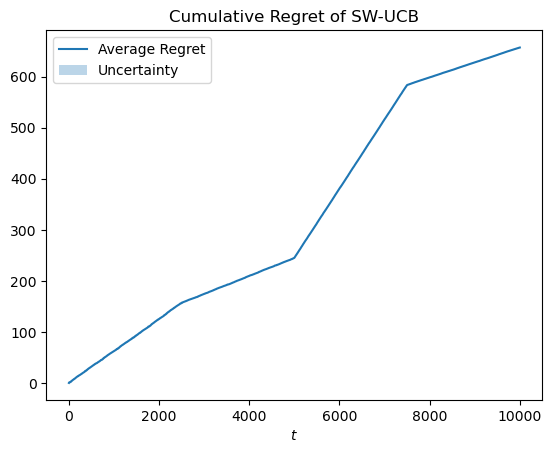

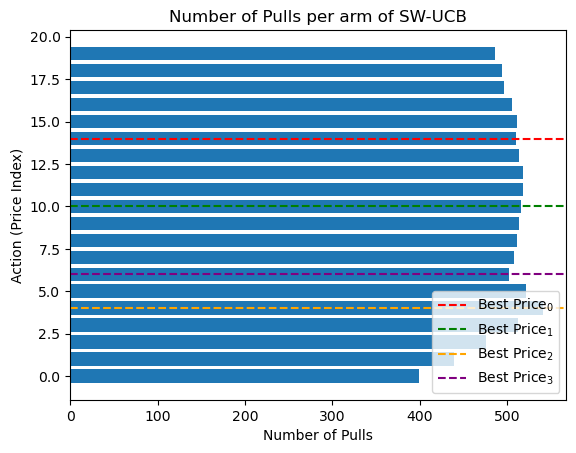

In [59]:
regret_per_trial = []

for seed in range(N_TRIALS):
    env = NonStationaryPricingEnvironment(conversion_probabilities, COST, INTERVAL_LENGTH, seed=seed)
    agent = SWUCBAgent(K, T, W)

    agent_rewards = np.array([])

    for t in range(T):
        price_index_t = agent.pull_arm()
        price_t = prices[price_index_t]
        demand_t, reward_t = env.round(price_t, N_CUSTOMERS)
        reward_t = rescale_reward(reward_t)
        agent.update(reward_t)

        agent_rewards = np.append(agent_rewards, reward_t)

    cumulative_regret = np.cumsum(expected_clairvoyant_rewards - agent_rewards)
    regret_per_trial.append(cumulative_regret)

regret_per_trial = np.array(regret_per_trial)

average_regret = regret_per_trial.mean(axis=0)
regret_std = regret_per_trial.std(axis=0)
regret_std_normalized = regret_std / np.sqrt(N_TRIALS)


# Plotting
plt.plot(np.arange(T), average_regret, label='Average Regret')
plt.fill_between(np.arange(T),
                 average_regret - regret_std_normalized,
                 average_regret + regret_std_normalized,
                 alpha=0.3,
                 label='Uncertainty')
plt.xlabel('$t$')
plt.legend()
plt.title('Cumulative Regret of SW-UCB')
plt.show()

plt.barh(np.arange(K), agent.n_pulls)
for i in range(N_INTERVALS):
    plt.axhline(y=best_prices_indices[i], color=COLORS[i], linestyle='--', label=f'Best Price$_{i}$')
plt.xlabel('Number of Pulls')
plt.ylabel('Action (Price Index)')
plt.legend()
plt.title('Number of Pulls per arm of SW-UCB')
plt.show()

## **CUSUM Approach**

In [60]:
class CUSUMUCBAgent:
    def __init__(self, K, T, M, h, alpha=0.99, range=1):
        self.K = K
        self.T = T
        self.M = M
        self.h = h
        self.alpha = alpha
        self.range = range
        self.action_t = None
        self.reset_times = np.zeros(K)
        self.n_pulls = np.zeros(K)
        self.all_rewards = [[] for _ in np.arange(K)]
        self.counters = np.repeat(M, K)
        self.average_rewards = np.zeros(K)
        self.n_resets = np.zeros(K)
        self.n_t = 0
        self.t = 0

    def pull_arm(self):
        if (self.counters > 0).any():
            for action in np.arange(self.K):
                if self.counters[action] > 0:
                    self.counters[action] -= 1
                    self.action_t = action
                    break
        else:
            if np.random.random() <= 1 - self.alpha:
                ucbs = self.average_rewards + self.range * np.sqrt(np.log(self.n_t) / self.n_pulls)
                self.action_t = np.argmax(ucbs)
            else:
                self.action_t = np.random.choice(np.arange(self.K)) # extra exploration
        return self.action_t

    def update(self, reward_t):
        self.n_pulls[self.action_t] += 1
        self.all_rewards[self.action_t].append(reward_t)
        if self.counters[self.action_t] == 0:
            if self.change_detection():
                self.n_resets[self.action_t] += 1
                self.n_pulls[self.action_t] = 0
                self.average_rewards[self.action_t] = 0
                self.counters[self.action_t] = self.M
                self.all_rewards[self.action_t] = []
                self.reset_times[self.action_t] = self.t
            else:
                self.average_rewards[self.action_t] += (reward_t - self.average_rewards[self.action_t]) / self.n_pulls[self.action_t]
        self.n_t = sum(self.n_pulls)
        self.t += 1

    def change_detection(self):
        """
        CUSUM CD sub-routine. This function returns 1 if there's evidence that the last pulled arm had a change in its mean reward.
        """
        u_0 = np.mean(self.all_rewards[self.action_t][:self.M])
        sp, sm = (np.array(self.all_rewards[self.action_t][self.M:]) - u_0, u_0 - np.array(self.all_rewards[self.action_t][self.M:]))
        gp, gm = 0, 0
        for sp_, sm_ in zip(sp, sm):
            gp, gm = max([0, gp + sp_]), max([0, gm + sm_])
            if max([gm, gm]) >= self.h:
                return 1
        return 0

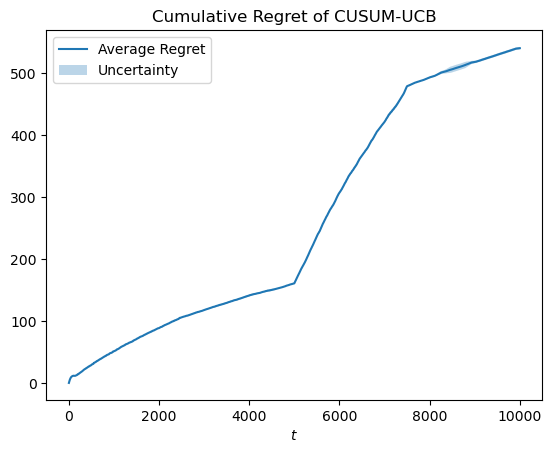

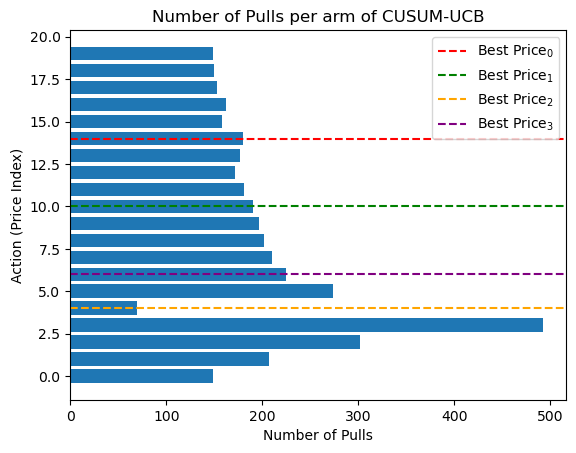

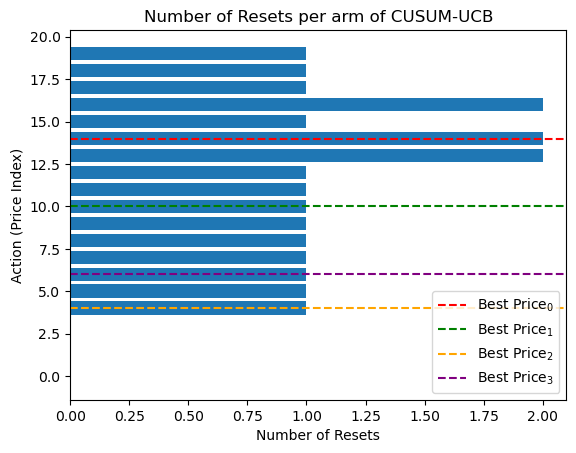

In [61]:
regret_per_trial = []

for seed in range(N_TRIALS):
    env = NonStationaryPricingEnvironment(conversion_probabilities, COST, INTERVAL_LENGTH, seed=seed)
    agent = CUSUMUCBAgent(K, T, M, h, alpha=alpha)

    agent_rewards = np.array([])

    for t in range(T):
        price_index_t = agent.pull_arm()
        price_t = prices[price_index_t]
        demand_t, reward_t = env.round(price_t, N_CUSTOMERS)
        reward_t = rescale_reward(reward_t)
        agent.update(reward_t)

        agent_rewards = np.append(agent_rewards, reward_t)

    cumulative_regret = np.cumsum(expected_clairvoyant_rewards - agent_rewards)
    regret_per_trial.append(cumulative_regret)

regret_per_trial = np.array(regret_per_trial)

average_regret = regret_per_trial.mean(axis=0)
regret_std = regret_per_trial.std(axis=0)
regret_std_normalized = regret_std / np.sqrt(N_TRIALS)


# Plotting
plt.plot(np.arange(T), average_regret, label='Average Regret')
plt.fill_between(np.arange(T),
                 average_regret - regret_std_normalized,
                 average_regret + regret_std_normalized,
                 alpha=0.3,
                 label='Uncertainty')
plt.xlabel('$t$')
plt.legend()
plt.title('Cumulative Regret of CUSUM-UCB')
plt.show()

plt.barh(np.arange(K), agent.n_pulls)
for i in range(N_INTERVALS):
    plt.axhline(y=best_prices_indices[i], color=COLORS[i], linestyle='--', label=f'Best Price$_{i}$')
plt.xlabel('Number of Pulls')
plt.ylabel('Action (Price Index)')
plt.legend()
plt.title('Number of Pulls per arm of CUSUM-UCB')
plt.show()

plt.barh(np.arange(K), agent.n_resets)
for i in range(N_INTERVALS):
    plt.axhline(y=best_prices_indices[i], color=COLORS[i], linestyle='--', label=f'Best Price$_{i}$')
plt.xlabel('Number of Resets')
plt.ylabel('Action (Price Index)')
plt.legend()
plt.title('Number of Resets per arm of CUSUM-UCB')
plt.show()